In [6]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Hiragino Sans'
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats as ss
import statsmodels.tsa as tsa
from statsmodels.sandbox.stats import runs
import datetime as dt
from dateutil.relativedelta import relativedelta
import locale

import finalib as fl

# 月や曜日を英語で取得するためこの設定をしておく
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

# E-Mini S&P500先物と金先物データ読み込み

In [3]:
dfsp_tmp = pd.read_csv('data/e-mini-sp500-200530/e-mini-sp500-daily.csv')
dfg_tmp = pd.read_csv(f'data/gold-200626/gold-daily.csv')
dfs = [dfsp_tmp, dfg_tmp]

# datetime indexに変換
def to_datetime_index(df):
    # DateTime列を追加
    df['datetime'] = (df['Date'] + '-' + df['Time']).map(lambda s: dt.datetime.strptime(s, '%m/%d/%Y-%H:%M'))
    df = df.set_index('datetime', drop=True)
    df = df.drop(columns=['Date', 'Time'])
    return df

dfs = [to_datetime_index(df) for df in dfs]

# 対数変換した列を追加
def add_log_values(df):
    df['logO'] = np.log(df['Open'])
    df['logH'] = np.log(df['High'])
    df['logL'] = np.log(df['Low'])
    df['logC'] = np.log(df['Close'])
    df['logV'] = np.log(df['Vol'])
    df['logOI'] = np.log(df['OI'])

_ = [add_log_values(df) for df in dfs]

/Users/leo/src/pyproject/sandbox/.venv/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/leo/src/pyproject/sandbox/.venv/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/leo/src/pyproject/sandbox/.venv/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# 価格、対数価格、価格階差、対数差収益率（100倍）のDFを作成

In [4]:
def to_log_return_ratio_df(df):
    diff_df = df.diff()
    close_df = df[['Close', 'logC']]
    diff_df = diff_df.rename(columns={'Close': 'CloseDiff', 'logC': 'logCDiff'})
    close_diff_df = diff_df[['CloseDiff', 'logCDiff']]
    rr_df = pd.concat([close_df, close_diff_df], axis=1)
    rr_df = rr_df.dropna()
    return rr_df

rr_dfs = [to_log_return_ratio_df(df) for df in dfs]

# 2019年の1年間のみのデータ

In [5]:
rrdfs2019 = [df[dt.datetime(2019, 1, 1):dt.datetime(2020, 1, 1)] for df in rr_dfs]

## 再度r(t-1)とr(t)の関係を散布図で描く（下の回帰モデルの結果を解釈するため）

Text(0.5, 1.0, '金先物の自己相関')

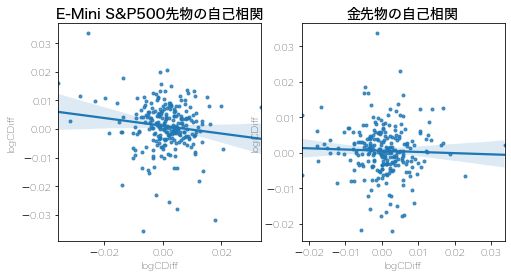

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
# S&P
sns.regplot(rrdfs2019[0]['logCDiff'][:-1], rrdfs2019[0]['logCDiff'][1:], ax=ax[0], marker='.')
ax[0].set_title('E-Mini S&P500先物の自己相関', fontsize=14, fontweight='bold')
# Gold
sns.regplot(rrdfs2019[1]['logCDiff'][:-1], rrdfs2019[1]['logCDiff'][1:], ax=ax[1], marker='.')
ax[1].set_title('金先物の自己相関', fontsize=14, fontweight='bold')

# 自己回帰モデル（AR(1)モデル）
autoregressive model：時系列データの自己回帰モデルの中で最も簡単で基本的なモデル

In [40]:
"""
ここではS&Pと金それぞれで1モデルの推定しかしていないからAIC,HQIC,BICには特に比較対象がないため意味は無い
S&Pと金どちらについても、回帰式の切片と傾きは上の散布図の結果と大体合っている（もちろん上のは単なる回帰プロットだから同じ結果では無いが）
"""

res_sp = tsa.ar_model.AutoReg(rrdfs2019[0]['logCDiff'].to_numpy(), lags=[1], trend='c', old_names=False).fit()
print(f"S&P500のAR(1)モデル　AIC: {res_sp.aic:0.3f}, HQIC: {res_sp.hqic:0.3f}, BIC: {res_sp.bic:0.3f}")
print(f"推定された回帰式：収益率r(t) = {res_sp.params[0]} + {res_sp.params[1]} × r(t-1) + ε(t)\n")

res_gold = tsa.ar_model.AutoReg(rrdfs2019[1]['logCDiff'].to_numpy(), lags=[1], trend='c', old_names=False).fit()
print(f"金先物のAR(1)モデル　AIC: {res_gold.aic:0.3f}, HQIC: {res_gold.hqic:0.3f}, BIC: {res_gold.bic:0.3f}")
print(f"推定された回帰式：収益率r(t) = {res_gold.params[0]} + {res_gold.params[1]} × r(t-1) + ε(t)")

S&P500のAR(1)モデル　AIC: -9.601, HQIC: -9.584, BIC: -9.559
推定された回帰式：収益率r(t) = 0.0011205147466286358 + -0.1362547629083485 × r(t-1) + ε(t)

金先物のAR(1)モデル　AIC: -9.902, HQIC: -9.885, BIC: -9.860
推定された回帰式：収益率r(t) = 0.0005679479149912506 + -0.03396852756073333 × r(t-1) + ε(t)
